In [41]:
import pandas as pd
import numpy as np
from obspy.clients.fdsn import Client
from pnwstore.mseed import WaveformClient
from datetime import datetime
import obspy
from matplotlib import pyplot as plt
from obspy import UTCDateTime

from obspy.geodetics import locations2degrees, degrees2kilometers
from tqdm import tqdm

## Morton Catalog

In [91]:
# Read Morton's catalog
events_morton = pd.read_csv('../data/ds01.csv')
# Convert the TSTRING to datetime
events_morton['datetime'] = pd.to_datetime(events_morton['TSTRING'], format='%Y%m%d%H%M%S', utc=True)
# Get the events in the Morton catalog that occurred on 10/14/2012
t1 = pd.Timestamp('2012-10-01 00:00:00.000000+0000', tz='UTC')
t2 = pd.Timestamp('2012-10-31 23:59:59.999999+0000', tz='UTC')

events_morton_201210= events_morton.loc[(events_morton['datetime'] > t1) & (events_morton['datetime'] < t2) ]

events_morton_201210.head()

,CI YEAR,TSTRING,YEAR,MONTH,DAY,HOUR,MINUTE,SECOND,LAT,LON,...,dist to nearest stn,tt RMS,ERH,ERZ,STRIKE,DIP,RAKE,PLATE DESIGNATION,TEMPLATE EVENT?,datetime
630,2.0,2.012100e+13,2012.0,10.0,1.0,4.0,32.0,57.05,40.7190,-125.9525,...,34.0,0.46,2.6,29.2,NaN,NaN,NaN,Seaward of Trench,NaN,2012-10-01 04:32:57+00:00
631,2.0,2.012100e+13,2012.0,10.0,1.0,23.0,30.0,58.38,40.5787,-124.8887,...,11.8,0.34,6.9,5.8,NaN,NaN,NaN,Slab,NaN,2012-10-01 23:30:58+00:00
632,2.0,2.012100e+13,2012.0,10.0,2.0,4.0,25.0,46.37,40.5592,-125.2087,...,24.1,0.30,1.7,5.0,NaN,NaN,NaN,Seaward of Trench,NaN,2012-10-02 04:25:46+00:00
633,2.0,2.012100e+13,2012.0,10.0,2.0,5.0,16.0,28.35,40.5075,-124.5450,...,7.3,0.35,1.1,1.2,NaN,NaN,NaN,Slab,NaN,2012-10-02 05:16:28+00:00
634,2.0,2.012100e+13,2012.0,10.0,2.0,6.0,17.0,18.88,40.4213,-125.3963,...,31.2,0.46,1.4,34.8,316.59,43.54,-85.95,Seaward of Trench,NaN,2012-10-02 06:17:18+00:00


In [110]:
events_morton_201210.keys()

Index(['CI YEAR', 'TSTRING', 'YEAR', 'MONTH', 'DAY', 'HOUR', 'MINUTE',
       'SECOND', 'LAT', 'LON', 'DEPTH', 'Md', 'Num P&S with weights > 0.1',
       'max az gap', 'dist to nearest stn', 'tt RMS', 'ERH', 'ERZ', 'STRIKE',
       'DIP', 'RAKE', 'PLATE DESIGNATION', 'TEMPLATE EVENT?', 'datetime'],
      dtype='object')

In [98]:
len(events_morton_201210)

91

## Our Catalog

In [93]:
# Load all the pick assignments 
mycatalog = pd.read_csv('../data/all_pick_assignments_october.csv')
# Convert the time series in all_pick_assignments to datetime
mycatalog['datetime'] = pd.to_datetime(mycatalog['time'], utc = True)
mycatalog=mycatalog.loc[(mycatalog['datetime'] > t1) & (mycatalog['datetime'] < t2) ]
mycatalog.head()

,Unnamed: 0,idx,time,x,y,z,picks,latitude,longitude,depth,event_idx,pick_idx,residual,station,phase,time_pick,datetime
0,0,4,2012-10-01 00:57:24.351689+00:00,7.588919,82.706331,0.390625,6,42.494557,-124.657684,0.390625,4,67646,0.684967,FS13B,P,1.349053e+09,2012-10-01 00:57:24.351689+00:00
1,1,4,2012-10-01 00:57:24.351689+00:00,7.588919,82.706331,0.390625,6,42.494557,-124.657684,0.390625,4,111915,-0.655013,G25B,P,1.349053e+09,2012-10-01 00:57:24.351689+00:00
2,2,4,2012-10-01 00:57:24.351689+00:00,7.588919,82.706331,0.390625,6,42.494557,-124.657684,0.390625,4,4333,0.254098,J25B,P,1.349053e+09,2012-10-01 00:57:24.351689+00:00
3,3,4,2012-10-01 00:57:24.351689+00:00,7.588919,82.706331,0.390625,6,42.494557,-124.657684,0.390625,4,150614,-1.278737,J25B,S,1.349053e+09,2012-10-01 00:57:24.351689+00:00
4,4,4,2012-10-01 00:57:24.351689+00:00,7.588919,82.706331,0.390625,6,42.494557,-124.657684,0.390625,4,170582,1.093668,J33B,S,1.349053e+09,2012-10-01 00:57:24.351689+00:00


In [112]:
list_events= []
time_threshold = 2
for i in range(len(events_morton_201210)):
    t1 = events_morton_201210.iloc[i]['datetime']
    matched_df = mycatalog.loc[(mycatalog['datetime'] > t1 - pd.Timedelta(time_threshold,'minutes')) & 
                               (mycatalog['datetime'] < t1 +pd.Timedelta(time_threshold,'minutes')) ]
    list_events.append(matched_df)
    print(i,len(list_events),len(matched_df), len(matched_df['time'].unique()), events_morton_201210.iloc[i]['Md'])

0 1 8 1 3.68
1 2 9 1 2.37
2 3 16 1 2.94
3 4 14 1 2.8
4 5 16 2 3.02
5 6 19 1 3.03
6 7 6 1 1.67
7 8 16 1 3.26
8 9 0 0 1.16
9 10 13 1 2.78
10 11 13 1 3.2
11 12 6 1 2.26
12 13 6 1 1.77
13 14 0 0 2.55
14 15 0 0 1.72
15 16 10 1 2.19
16 17 11 1 2.26
17 18 16 1 3.21
18 19 13 1 2.78
19 20 18 1 2.75
20 21 19 1 3.13
21 22 11 1 2.83
22 23 12 1 2.71
23 24 6 1 2.44
24 25 9 1 2.65
25 26 11 1 2.43
26 27 16 1 3.14
27 28 17 2 2.95
28 29 20 1 3.04
29 30 0 0 2.5
30 31 17 1 3.0
31 32 0 0 1.61
32 33 0 0 1.9
33 34 16 1 2.5
34 35 0 0 2.45
35 36 18 2 2.51
36 37 9 1 2.97
37 38 10 1 2.6
38 39 0 0 2.59
39 40 10 1 2.55
40 41 10 1 2.65
41 42 12 1 2.43
42 43 13 1 2.78
43 44 0 0 1.94
44 45 16 1 2.57
45 46 9 1 2.74
46 47 13 1 2.57
47 48 0 0 2.09
48 49 13 1 2.76
49 50 26 1 3.33
50 51 0 0 1.5
51 52 10 1 2.44
52 53 10 1 2.91
53 54 7 1 2.35
54 55 17 2 2.91
55 56 10 1 2.45
56 57 17 1 2.9
57 58 14 1 2.96
58 59 14 2 4.26
59 60 15 2 4.06
60 61 10 1 2.55
61 62 14 1 2.99
62 63 19 2 2.81
63 64 11 1 2.8
64 65 19 1 3.81
65 66 0 0 

In [103]:
print(list_events[0])
print()

    Unnamed: 0  idx                              time           x           y  \
12          12   20  2012-10-01 04:32:57.538387+00:00 -111.498739 -112.407549   
13          13   20  2012-10-01 04:32:57.538387+00:00 -111.498739 -112.407549   
14          14   20  2012-10-01 04:32:57.538387+00:00 -111.498739 -112.407549   
15          15   20  2012-10-01 04:32:57.538387+00:00 -111.498739 -112.407549   
16          16   20  2012-10-01 04:32:57.538387+00:00 -111.498739 -112.407549   
17          17   20  2012-10-01 04:32:57.538387+00:00 -111.498739 -112.407549   
18          18   20  2012-10-01 04:32:57.538387+00:00 -111.498739 -112.407549   
19          19   20  2012-10-01 04:32:57.538387+00:00 -111.498739 -112.407549   

            z  picks   latitude  longitude      depth  event_idx  pick_idx  \
12  27.734375      8  40.730307 -126.06985  27.734375         20    201109   
13  27.734375      8  40.730307 -126.06985  27.734375         20    154614   
14  27.734375      8  40.730307 -126

In [ ]:
print()

In [48]:
# Print the events in my catalog that match with the event in Morton's catalog
event_morton_2021014_023944

,Unnamed: 0,idx,time,x,y,z,picks,latitude,longitude,depth,event_idx,pick_idx,residual,station,phase,time_pick,datetime
2285,2285,1568,2012-10-14 02:39:43.926355+00:00,15.761602,-168.807655,49.609375,12,40.229798,-124.564802,49.609375,1568,55255,0.724059,FS09B,P,1.350182e+09,2012-10-14 02:39:43.926355+00:00
2286,2286,1568,2012-10-14 02:39:43.926355+00:00,15.761602,-168.807655,49.609375,12,40.229798,-124.564802,49.609375,1568,191232,-0.314155,FS09B,S,1.350182e+09,2012-10-14 02:39:43.926355+00:00
2287,2287,1568,2012-10-14 02:39:43.926355+00:00,15.761602,-168.807655,49.609375,12,40.229798,-124.564802,49.609375,1568,143917,-0.464841,FS13B,P,1.350182e+09,2012-10-14 02:39:43.926355+00:00
2288,2288,1568,2012-10-14 02:39:43.926355+00:00,15.761602,-168.807655,49.609375,12,40.229798,-124.564802,49.609375,1568,268393,0.010119,FS13B,S,1.350182e+09,2012-10-14 02:39:43.926355+00:00
2289,2289,1568,2012-10-14 02:39:43.926355+00:00,15.761602,-168.807655,49.609375,12,40.229798,-124.564802,49.609375,1568,140796,-0.523190,FS17B,P,1.350182e+09,2012-10-14 02:39:43.926355+00:00
2290,2290,1568,2012-10-14 02:39:43.926355+00:00,15.761602,-168.807655,49.609375,12,40.229798,-124.564802,49.609375,1568,266057,-0.085016,FS17B,S,1.350182e+09,2012-10-14 02:39:43.926355+00:00
2291,2291,1568,2012-10-14 02:39:43.926355+00:00,15.761602,-168.807655,49.609375,12,40.229798,-124.564802,49.609375,1568,142618,0.166459,FS20B,P,1.350182e+09,2012-10-14 02:39:43.926355+00:00
2292,2292,1568,2012-10-14 02:39:43.926355+00:00,15.761602,-168.807655,49.609375,12,40.229798,-124.564802,49.609375,1568,267331,0.804205,FS20B,S,1.350182e+09,2012-10-14 02:39:43.926355+00:00
2293,2293,1568,2012-10-14 02:39:43.926355+00:00,15.761602,-168.807655,49.609375,12,40.229798,-124.564802,49.609375,1568,747,-0.344330,G10B,P,1.350182e+09,2012-10-14 02:39:43.926355+00:00
2294,2294,1568,2012-10-14 02:39:43.926355+00:00,15.761602,-168.807655,49.609375,12,40.229798,-124.564802,49.609375,1568,147714,-0.366297,G10B,S,1.350182e+09,2012-10-14 02:39:43.926355+00:00


In [49]:
# Print the events in my catalog that match with the event in Morton's catalog
event_morton_2021014_030801

,Unnamed: 0,idx,time,x,y,z,picks,latitude,longitude,depth,event_idx,pick_idx,residual,station,phase,time_pick,datetime
2297,2297,1570,2012-10-14 03:08:01.434268+00:00,30.939441,-96.402113,49.609375,13,40.881398,-124.382923,49.609375,1570,191233,-0.045203,FS09B,S,1.350184e+09,2012-10-14 03:08:01.434268+00:00
2298,2298,1570,2012-10-14 03:08:01.434268+00:00,30.939441,-96.402113,49.609375,13,40.881398,-124.382923,49.609375,1570,143926,-0.550344,FS13B,P,1.350184e+09,2012-10-14 03:08:01.434268+00:00
2299,2299,1570,2012-10-14 03:08:01.434268+00:00,30.939441,-96.402113,49.609375,13,40.881398,-124.382923,49.609375,1570,268405,1.129425,FS13B,S,1.350184e+09,2012-10-14 03:08:01.434268+00:00
2300,2300,1570,2012-10-14 03:08:01.434268+00:00,30.939441,-96.402113,49.609375,13,40.881398,-124.382923,49.609375,1570,177473,1.024022,FS16B,S,1.350184e+09,2012-10-14 03:08:01.434268+00:00
2301,2301,1570,2012-10-14 03:08:01.434268+00:00,30.939441,-96.402113,49.609375,13,40.881398,-124.382923,49.609375,1570,140807,-0.749436,FS17B,P,1.350184e+09,2012-10-14 03:08:01.434268+00:00
2302,2302,1570,2012-10-14 03:08:01.434268+00:00,30.939441,-96.402113,49.609375,13,40.881398,-124.382923,49.609375,1570,266063,0.609988,FS17B,S,1.350184e+09,2012-10-14 03:08:01.434268+00:00
2303,2303,1570,2012-10-14 03:08:01.434268+00:00,30.939441,-96.402113,49.609375,13,40.881398,-124.382923,49.609375,1570,142621,-0.688690,FS20B,P,1.350184e+09,2012-10-14 03:08:01.434268+00:00
2304,2304,1570,2012-10-14 03:08:01.434268+00:00,30.939441,-96.402113,49.609375,13,40.881398,-124.382923,49.609375,1570,267335,-1.107447,FS20B,S,1.350184e+09,2012-10-14 03:08:01.434268+00:00
2305,2305,1570,2012-10-14 03:08:01.434268+00:00,30.939441,-96.402113,49.609375,13,40.881398,-124.382923,49.609375,1570,749,-0.769603,G10B,P,1.350184e+09,2012-10-14 03:08:01.434268+00:00
2306,2306,1570,2012-10-14 03:08:01.434268+00:00,30.939441,-96.402113,49.609375,13,40.881398,-124.382923,49.609375,1570,147716,-0.604589,G10B,S,1.350184e+09,2012-10-14 03:08:01.434268+00:00


In [50]:
# Print the events in my catalog that match with the event in Morton's catalog
event_morton_2021014_164833

,Unnamed: 0,idx,time,x,y,z,picks,latitude,longitude,depth,event_idx,pick_idx,residual,station,phase,time_pick,datetime
2399,2399,1632,2012-10-14 16:53:05.402505+00:00,-58.960066,-123.077839,37.890625,26,40.639663,-125.446993,37.890625,1632,55380,-0.022246,FS09B,P,1.350234e+09,2012-10-14 16:53:05.402505+00:00
2400,2400,1632,2012-10-14 16:53:05.402505+00:00,-58.960066,-123.077839,37.890625,26,40.639663,-125.446993,37.890625,1632,191333,-0.108078,FS09B,S,1.350234e+09,2012-10-14 16:53:05.402505+00:00
2401,2401,1632,2012-10-14 16:53:05.402505+00:00,-58.960066,-123.077839,37.890625,26,40.639663,-125.446993,37.890625,1632,144215,-0.188136,FS13B,P,1.350234e+09,2012-10-14 16:53:05.402505+00:00
2402,2402,1632,2012-10-14 16:53:05.402505+00:00,-58.960066,-123.077839,37.890625,26,40.639663,-125.446993,37.890625,1632,268535,-0.256534,FS13B,S,1.350234e+09,2012-10-14 16:53:05.402505+00:00
2403,2403,1632,2012-10-14 16:53:05.402505+00:00,-58.960066,-123.077839,37.890625,26,40.639663,-125.446993,37.890625,1632,35687,0.237993,FS16B,P,1.350234e+09,2012-10-14 16:53:05.402505+00:00
2404,2404,1632,2012-10-14 16:53:05.402505+00:00,-58.960066,-123.077839,37.890625,26,40.639663,-125.446993,37.890625,1632,177663,0.480991,FS16B,S,1.350234e+09,2012-10-14 16:53:05.402505+00:00
2405,2405,1632,2012-10-14 16:53:05.402505+00:00,-58.960066,-123.077839,37.890625,26,40.639663,-125.446993,37.890625,1632,141098,0.522280,FS17B,P,1.350234e+09,2012-10-14 16:53:05.402505+00:00
2406,2406,1632,2012-10-14 16:53:05.402505+00:00,-58.960066,-123.077839,37.890625,26,40.639663,-125.446993,37.890625,1632,266201,-0.910331,FS17B,S,1.350234e+09,2012-10-14 16:53:05.402505+00:00
2407,2407,1632,2012-10-14 16:53:05.402505+00:00,-58.960066,-123.077839,37.890625,26,40.639663,-125.446993,37.890625,1632,142751,-0.516596,FS20B,P,1.350234e+09,2012-10-14 16:53:05.402505+00:00
2408,2408,1632,2012-10-14 16:53:05.402505+00:00,-58.960066,-123.077839,37.890625,26,40.639663,-125.446993,37.890625,1632,267449,-1.016373,FS20B,S,1.350234e+09,2012-10-14 16:53:05.402505+00:00


In [51]:
client = WaveformClient()
client2 = Client("IRIS")

In [52]:
# Get the list of stations
station_list = ['FS09B',
 'FS13B',
 'FS16B',
 'FS17B',
 'FS20B',
 'G10B',
 'G17B',
 'G19B',
 'G25B',
 'G26B',
 'G27B',
 'J09B',
 'J25B',
 'J33B',
 'M09B',
 'M12B',
 'M14B']

In [72]:
mycatalog[mycatalog['idx'] == 9]

,Unnamed: 0,idx,time,x,y,z,picks,latitude,longitude,depth,event_idx,pick_idx,residual,station,phase,time_pick,datetime
6,6,9,2012-10-01 01:36:43.089506+00:00,-99.823478,21.733243,49.609375,6,41.939361,-125.953707,49.609375,9,154575,0.588473,FS16B,S,1.349055e+09,2012-10-01 01:36:43.089506+00:00
7,7,9,2012-10-01 01:36:43.089506+00:00,-99.823478,21.733243,49.609375,6,41.939361,-125.953707,49.609375,9,116106,-0.962265,FS17B,P,1.349055e+09,2012-10-01 01:36:43.089506+00:00
8,8,9,2012-10-01 01:36:43.089506+00:00,-99.823478,21.733243,49.609375,6,41.939361,-125.953707,49.609375,9,215133,0.268530,FS20B,S,1.349055e+09,2012-10-01 01:36:43.089506+00:00
9,9,9,2012-10-01 01:36:43.089506+00:00,-99.823478,21.733243,49.609375,6,41.939361,-125.953707,49.609375,9,134135,0.638193,M09B,P,1.349055e+09,2012-10-01 01:36:43.089506+00:00
10,10,9,2012-10-01 01:36:43.089506+00:00,-99.823478,21.733243,49.609375,6,41.939361,-125.953707,49.609375,9,104145,-0.595106,M12B,P,1.349055e+09,2012-10-01 01:36:43.089506+00:00
11,11,9,2012-10-01 01:36:43.089506+00:00,-99.823478,21.733243,49.609375,6,41.939361,-125.953707,49.609375,9,234957,0.062176,M12B,S,1.349055e+09,2012-10-01 01:36:43.089506+00:00


In [54]:
mycatalog['station'].unique()

array(['FS13B', 'G25B', 'J25B', 'J33B', 'M12B', 'FS16B', 'FS17B', 'FS20B',
       'M09B', 'G10B', 'G19B', 'FS09B', 'M14B', 'G17B', 'J09B', 'G26B',
       'G27B'], dtype=object)

In [55]:
distances

{'FS16B': 22.976654541948474,
 'FS17B': 23.99429363189918,
 'FS13B': 28.48602082567876,
 'M14B': 29.668964314057174,
 'FS09B': 34.47269178722089,
 'FS20B': 46.38911307982181,
 'G17B': 68.64657323532724,
 'G10B': 68.69248304206646,
 'G19B': 106.71142014127307,
 'G25B': 131.329973741835,
 'G26B': 136.14972293586126,
 'M12B': 160.93208595898352,
 'G27B': 168.18863508100011,
 'J09B': 267.56986944669507,
 'M09B': 390.59436557586747,
 'J25B': 414.49581671894094,
 'J33B': 485.2224023162967}

In [56]:
distances.keys()

dict_keys(['FS16B', 'FS17B', 'FS13B', 'M14B', 'FS09B', 'FS20B', 'G17B', 'G10B', 'G19B', 'G25B', 'G26B', 'M12B', 'G27B', 'J09B', 'M09B', 'J25B', 'J33B'])

2012-10-14T01:23:44.999266Z


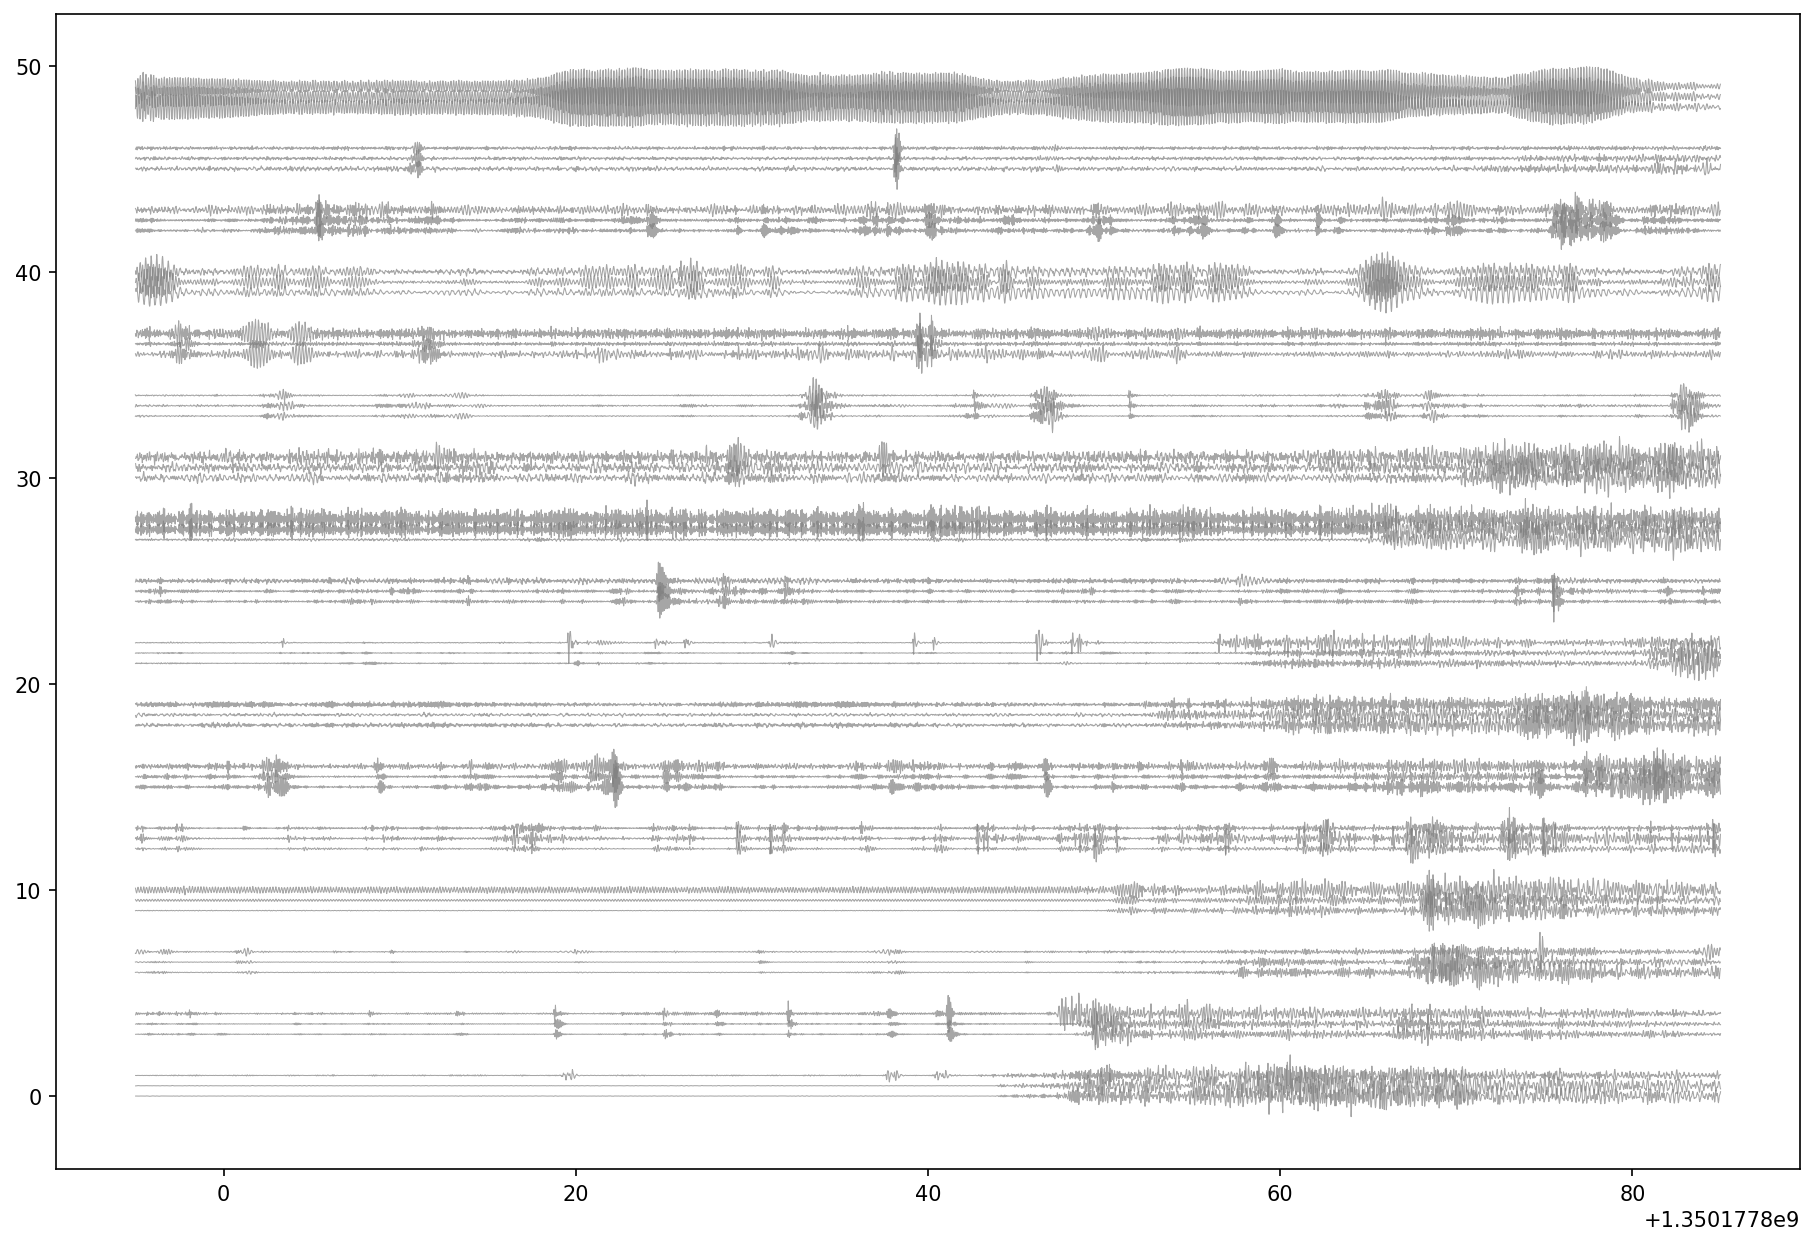

In [84]:
idx = 0
otime = UTCDateTime(mycatalog['datetime'].unique()[idx])
distances = {}
for i, sta in enumerate(station_list):
    sta_inv = client2.get_stations(network = "7D", station = sta, channel = "?H?", 
                     starttime = otime - 1e4, endtime = otime + 1e4)[0][0]
    slat = sta_inv.latitude
    slon = sta_inv.longitude
    olat = mycatalog['latitude'].unique()[idx]
    olon = mycatalog['longitude'].unique()[idx]

    dis1 = locations2degrees(olat, olon, slat, slon)
    dist = degrees2kilometers(dis1)
    distances[sta] = dist
distances = {k: v for k, v in sorted(distances.items(), key=lambda item: item[1])}
# print(distances.keys())
print(otime)
plt.figure(figsize=(15,10), dpi=150)
for i, sta in enumerate(distances.keys()):
    st = client.get_waveforms(network="7D", station=sta, channel="?H?", year=2012, month=10, day=14)
    st = obspy.Stream(filter(lambda st:st.stats.sampling_rate>10, st))
    st.filter(type='bandpass',freqmin=4,freqmax=15)

    trim_st = st.copy().trim(starttime = otime - 30, 
                endtime = otime + 60)
    if len(trim_st)>0:
        trim_st = trim_st.normalize()
        offsets1  = np.arange(0,len(trim_st))
        offsets2 = np.arange(0,len(station_list)* (len(trim_st)),len(trim_st))

        for ii in range(len(trim_st)):
            plt.plot(trim_st[ii].times(type='utcdatetime'), trim_st[ii].data+offsets1[ii]*0.5+offsets2[i], 
                     color = 'gray', alpha=0.7, lw=0.5)    
        time_pick = [[x['time_pick'], x['phase']] for _, x in mycatalog[mycatalog['idx'] == idx].iterrows() 
                     if x['station'] == sta]
        if len(time_pick) > 0:
            for p in time_pick:
                if p[1] == 'P':
                    plt.vlines(p[0], offsets1[ii]*0.5+offsets2[i]-1, 
                                     offsets1[ii]*0.5+offsets2[i]+1, color='r')
                else:
                    plt.vlines(p[0], offsets1[ii]*0.5+offsets2[i]-1, 
                                     offsets1[ii]*0.5+offsets2[i]+1, color='b')
    else:                 
        pass 


In [69]:
st = client.get_waveforms(network="7D", station='FS16B', channel="?H?", year=2012, month=10, day=14)
st = obspy.Stream(filter(lambda st:st.stats.sampling_rate>10, st))
st.filter(type='bandpass',freqmin=4,freqmax=15)

trim_st = st.copy().trim(starttime = otime - 30, 
            endtime = otime + 60)
trim_st
st

3 Trace(s) in Stream:
7D.FS16B..HH1 | 2012-10-14T00:00:00.004500Z - 2012-10-14T23:59:59.996500Z | 125.0 Hz, 10800000 samples
7D.FS16B..HH2 | 2012-10-14T00:00:00.004500Z - 2012-10-14T23:59:59.996500Z | 125.0 Hz, 10800000 samples
7D.FS16B..HHZ | 2012-10-14T00:00:00.004500Z - 2012-10-14T23:59:59.996500Z | 125.0 Hz, 10800000 samples

In [70]:
otime

2012-10-01T17:18:00.934549Z